In [1]:
import pandas as pd
import numpy as np

In [2]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

In [3]:
from tqdm import tqdm_notebook as tqdm

In [4]:
train = pd.read_csv("../dataset/original/train.csv")
test = pd.read_csv("../dataset/original/x_test.csv")

In [5]:
train.shape

(5719, 11)

In [6]:
test.shape

(300, 10)

In [7]:
test

,Unnamed: 0,sku,pack,size (GM),brand,price,POS_exposed w-1,volume_on_promo w-1,sales w-1,scope
0,WE 29 June 2019,1027,SINGLE,114.23,BRAND2,0.56,10.0,24.386541,66337.0,1
1,WE 06 July 2019,1027,SINGLE,114.23,BRAND2,0.55,4.0,37.437842,49992.0,1
2,WE 13 July 2019,1027,SINGLE,114.23,BRAND2,0.45,0.0,28.039623,58062.0,1
3,WE 20 July 2019,1027,SINGLE,114.23,BRAND2,0.50,19.0,100.000000,90908.0,1
4,WE 27 July 2019,1027,SINGLE,114.23,BRAND2,0.42,26.0,99.191839,108957.0,1
...,...,...,...,...,...,...,...,...,...,...
295,WE 16 November 2019,1206,SINGLE,125.65,BRAND4,0.41,19.0,98.800841,111353.0,1
296,WE 23 November 2019,1206,SINGLE,125.65,BRAND4,0.57,2.0,99.129248,63359.0,1
297,WE 30 November 2019,1206,SINGLE,125.65,BRAND4,0.57,0.0,28.696578,35238.0,1
298,WE 07 December 2019,1206,SINGLE,125.65,BRAND4,0.56,2.0,18.972899,34242.0,1


In [8]:
def convert_date(df):
    df['Unnamed: 0'] = df['Unnamed: 0'].str.split(" ")
    df['Unnamed: 0'] = df['Unnamed: 0'].apply(lambda x: "-".join(x[1:]))
    df = df.rename(columns={'Unnamed: 0':'Date'})
    df.Date = pd.to_datetime(df.Date)
    return df

In [9]:
df = pd.concat([train, test])

In [10]:
df = convert_date(df)

In [11]:
df = df.sort_values(['sku','Date'])
df = df.reset_index(drop=True)

# Encoding Categorical Features

In [12]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
df.pack = le.fit_transform(df.pack)
le.classes_

array(['MULTI', 'SINGLE'], dtype=object)

In [13]:
df.brand = le.fit_transform(df.brand)
le.classes_

array(['BRAND1', 'BRAND2', 'BRAND3', 'BRAND4', 'BRAND5'], dtype=object)

In [14]:
df

,Date,sku,pack,size (GM),brand,price,POS_exposed w-1,volume_on_promo w-1,sales w-1,scope,target
0,2016-12-10,144,0,114.23,1,2.18,NaN,NaN,NaN,1,51320.0
1,2016-12-17,144,0,114.23,1,2.00,45.0,100.000000,51320.0,1,66431.0
2,2016-12-24,144,0,114.23,1,2.05,17.0,100.000000,66431.0,1,57001.0
3,2016-12-31,144,0,114.23,1,3.00,2.0,100.000000,57001.0,1,15052.0
4,2017-01-07,144,0,114.23,1,2.99,2.0,28.534193,15052.0,1,22016.0
...,...,...,...,...,...,...,...,...,...,...,...
6014,2019-05-25,2718,1,395.41,0,1.11,0.0,26.050480,33875.0,0,33328.0
6015,2019-06-01,2718,1,395.41,0,1.30,1.0,43.099496,33328.0,0,22512.0
6016,2019-06-08,2718,1,395.41,0,1.55,0.0,0.000000,22512.0,0,17461.0
6017,2019-06-15,2718,1,395.41,0,1.55,0.0,0.000000,17461.0,0,17105.0


In [15]:
train = df[~df.target.isna()]
train.shape

(5719, 11)

In [16]:
test = df[df.target.isna()]
test.shape

(300, 11)

# Imputing NaNs in the first week

In [68]:
# Linear Regression/ Linear Interpolation

In [94]:
def inverse_interpolation(df, date='2016-12-10'):
    first_we_idx = df[df.Date==pd.to_datetime(date)].index

    df = df.sort_values(['sku', 'Date'])
    for i in first_we_idx:
        inverse_interpolation = 2*df.loc[i+1, 'sales w-1'] - df.loc[i+2, 'sales w-1']
        df.loc[i,'sales w-1'] = inverse_interpolation
    
    return df

df = inverse_interpolation(df)

In [98]:
df

,Date,sku,pack,size (GM),brand,price,POS_exposed w-1,volume_on_promo w-1,sales w-1,scope,target
0,2016-12-10,144,0,114.23,1,2.18,NaN,NaN,36209.0,1,51320.0
1,2016-12-17,144,0,114.23,1,2.00,45.0,100.000000,51320.0,1,66431.0
2,2016-12-24,144,0,114.23,1,2.05,17.0,100.000000,66431.0,1,57001.0
3,2016-12-31,144,0,114.23,1,3.00,2.0,100.000000,57001.0,1,15052.0
4,2017-01-07,144,0,114.23,1,2.99,2.0,28.534193,15052.0,1,22016.0
...,...,...,...,...,...,...,...,...,...,...,...
6014,2019-05-25,2718,1,395.41,0,1.11,0.0,26.050480,33875.0,0,33328.0
6015,2019-06-01,2718,1,395.41,0,1.30,1.0,43.099496,33328.0,0,22512.0
6016,2019-06-08,2718,1,395.41,0,1.55,0.0,0.000000,22512.0,0,17461.0
6017,2019-06-15,2718,1,395.41,0,1.55,0.0,0.000000,17461.0,0,17105.0


# Plot

In [17]:
mycolors = np.random.choice(list(mpl.colors.XKCD_COLORS.keys()), len(set(df.sku)), replace=False)

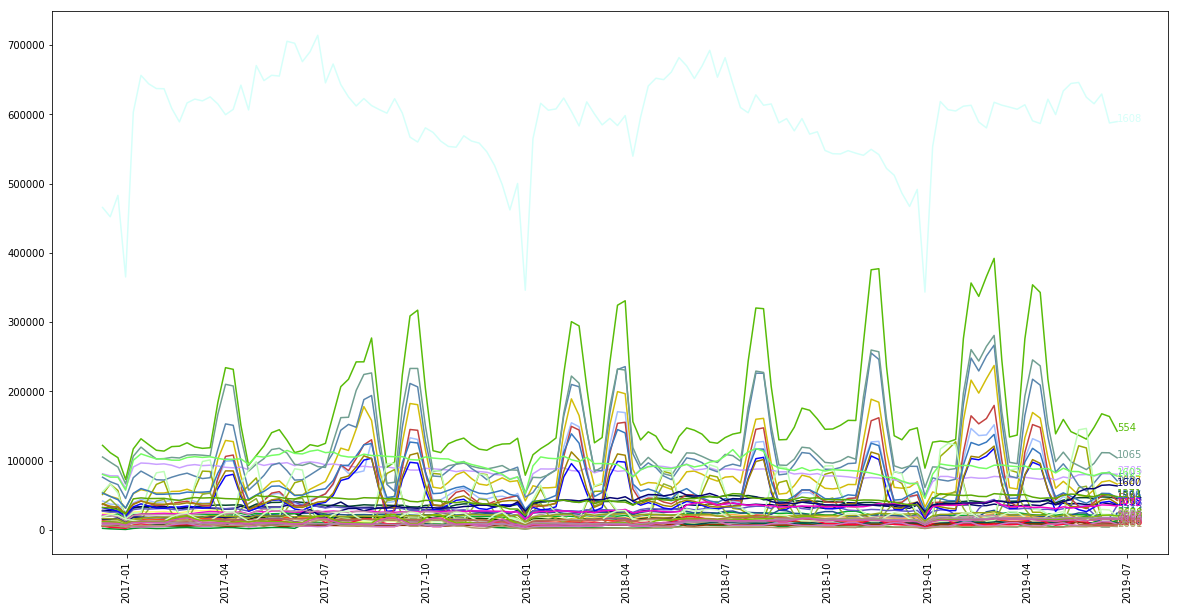

In [18]:
plt.figure(figsize=(20,10))
plt.xticks(rotation=90)
for i, s in enumerate(set(train.sku)):
    plt.plot(train[train.sku==s].Date, train[train.sku==s].target,  color=mycolors[i])
    last_x, last_y = train[train.sku==s].Date.values[-1], train[train.sku==s].target.values[-1]
    plt.text(last_x, last_y, str(s), color=mycolors[i])

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and pos

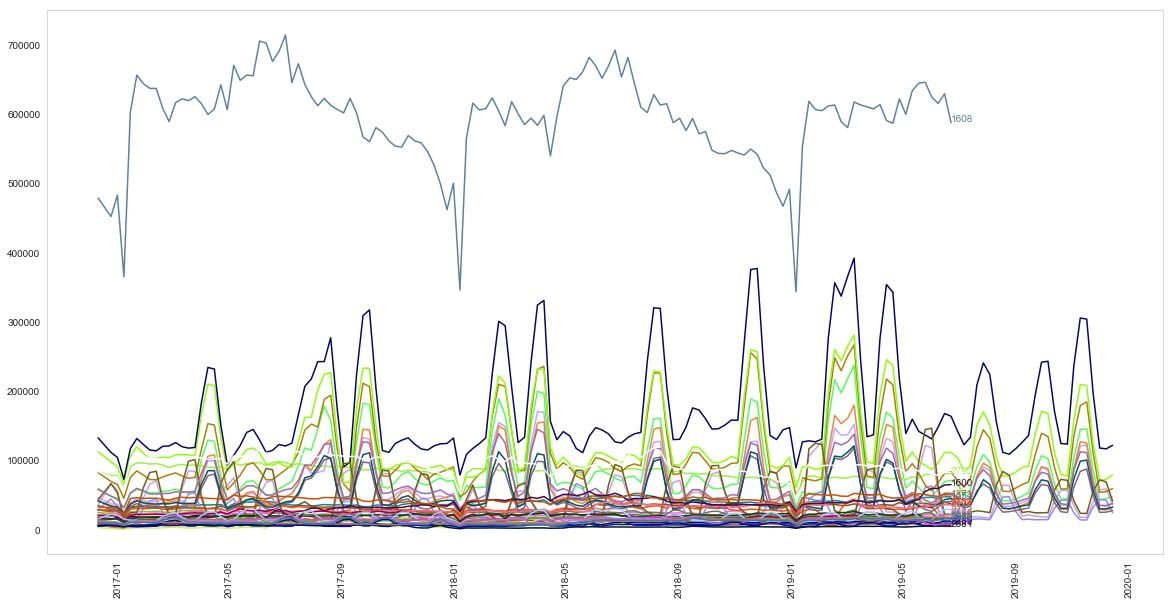

In [106]:
# Adding test flow [only for the series to be predicted]
mycolors = np.random.choice(list(mpl.colors.XKCD_COLORS.keys()), len(set(df.sku)), replace=False)
plt.figure(figsize=(20,10))
plt.xticks(rotation=90)
for i, s in enumerate(set(train.sku)):
    plt.plot(df[df.sku==s].Date, df[df.sku==s]['sales w-1'],  color=mycolors[i])
    last_x, last_y = df[df.sku==s].Date.values[-1], df[df.sku==s].target.values[-1]
    plt.text(last_x, last_y, str(s), color=mycolors[i])

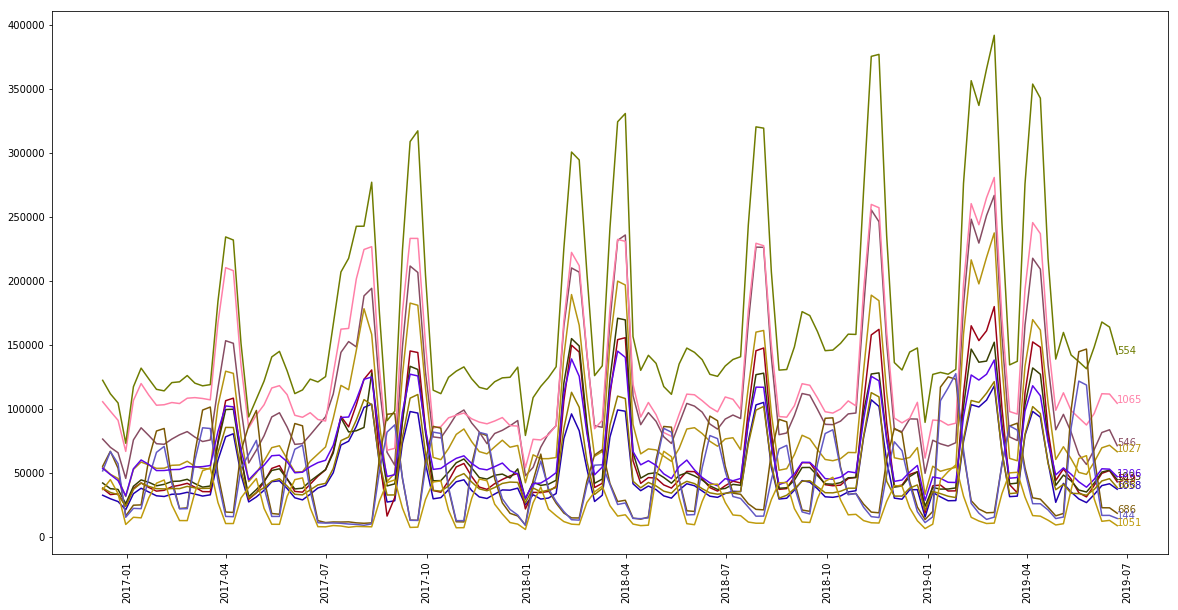

In [19]:
# Time series of sku to be predicted 
mycolors = np.random.choice(list(mpl.colors.XKCD_COLORS.keys()), len(set(train[train.scope == 1].sku)), replace=False)
plt.figure(figsize=(20,10))
plt.xticks(rotation=90)
for i, s in enumerate(set(train[train.scope == 1].sku)):
    plt.plot(train[train.sku==s].Date, train[train.sku==s].target,  color=mycolors[i])
    last_x, last_y = train[train.sku==s].Date.values[-1], train[train.sku==s].target.values[-1]
    plt.text(last_x, last_y, str(s), color=mycolors[i])

In [20]:
train = train.sort_values(['sku', 'Date'])
train = train.reset_index(drop=True)

## Target Distribution

In [146]:
df.target.idxmax()

2988

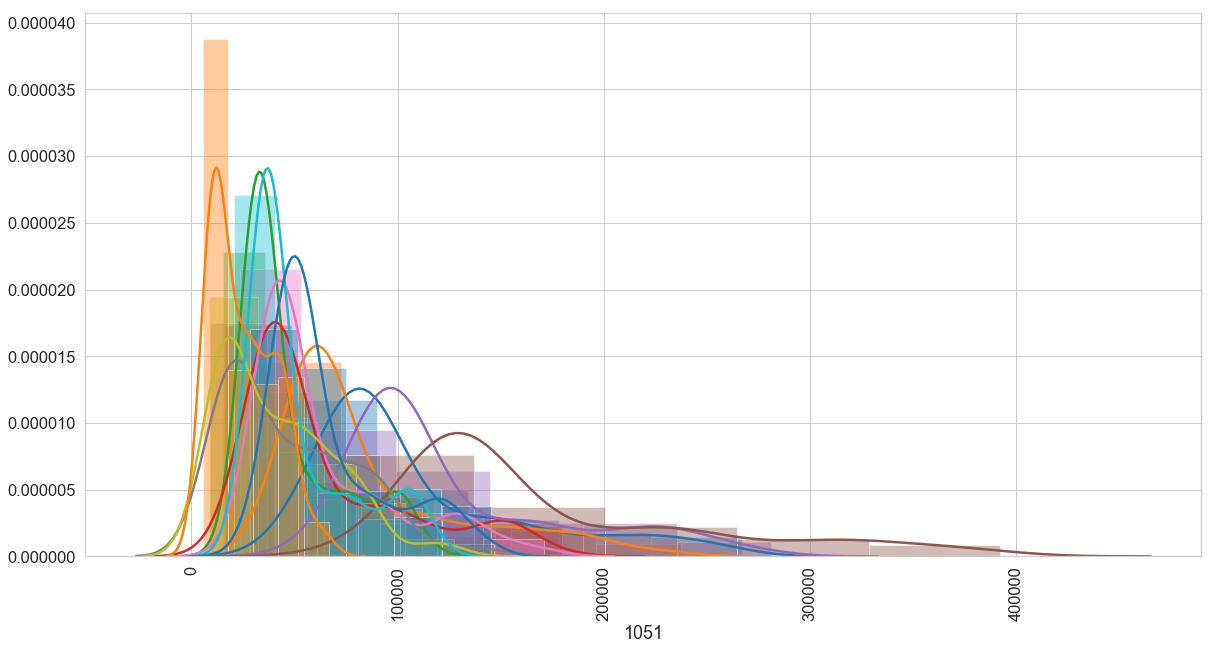

In [181]:
mycolors = np.random.choice(list(mpl.colors.XKCD_COLORS.keys()), len(set(train[train.scope == 1].sku)), replace=False)
plt.figure(figsize=(20,10))
plt.xticks(rotation=90)
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})
for i, s in enumerate(set(train[train.scope == 1].sku)):
    dp = sns.distplot(df[df.sku==s]['sales w-1'],bins=5)
    #max_x, max_y = train[(train.sku==s) & ()].Date.values[-1], train[train.sku==s].target.values[-1]
    #plt.text(last_x, last_y, str(s), color=mycolors[i])

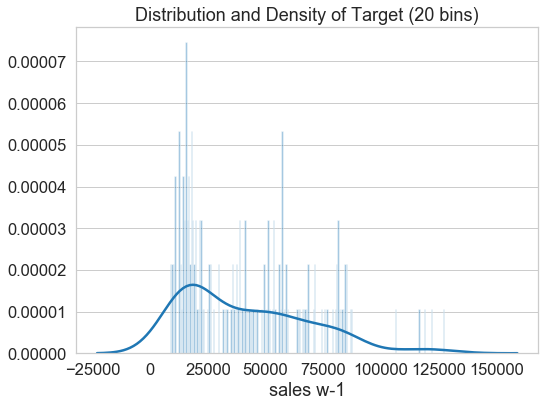

In [142]:
plt.figure(figsize=(8, 6))
sns.set_style("whitegrid")
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})
dp = sns.distplot(df[df.sku==s]['sales w-1'],bins=5)
dp.set_title('Distribution and Density of Target (20 bins)')
plt.grid(axis='x')
#plt.xlim([4,8])
plt.tight_layout()

In [148]:
from scipy import stats

In [172]:
p_values = {}
for s in set(train.sku):
    p_values[s] = stats.kstest(df[df.sku==s]['sales w-1'].values, 'norm')

In [175]:
x = np.linspace(-15, 15, 9)

In [176]:
x

array([-15.  , -11.25,  -7.5 ,  -3.75,   0.  ,   3.75,   7.5 ,  11.25,
        15.  ])

In [177]:
df[df.sku==144]['sales w-1'].values

array([ 36209.,  51320.,  66431.,  57001.,  15052.,  22016.,  21762.,
        46125.,  65842.,  70514.,  41614.,  21685.,  21758.,  59613.,
        85052.,  84513.,  43460.,  15706.,  15491.,  53438.,  64206.,
        75255.,  37998.,  15685.,  15708.,  49597.,  68260.,  71521.,
        35623.,  10760.,  10504.,  10576.,  10325.,   9764.,   9442.,
         8766.,   9857.,  50567.,  81713.,  87335.,  45964.,  12669.,
        12592.,  53695.,  81664.,  80639.,  38457.,  12395.,  12423.,
        51705.,  81455.,  79973.,  49413.,  29506.,  21145.,  16816.,
         8653.,  38594.,  59021.,  37561.,  27415.,  19600.,  13141.,
        12789.,  39941.,  55795.,  56156.,  40720.,  25060.,  26241.,
        14149.,  13964.,  14546.,  56268.,  84581.,  81622.,  44177.,
        16880.,  17137.,  53912.,  78975.,  76574.,  51054.,  31301.,
        29750.,  22987.,  15892.,  15958.,  44344.,  68490.,  71312.,
        38884.,  19232.,  17613.,  56764.,  80561.,  83527.,  53263.,
        32737.,  335

## Average Sales per sku

In [21]:
avg = train[['sku', 'target']].groupby('sku').mean()

In [22]:
avg.target.values

array([ 42686.89473684, 111831.5112782 ,  64297.36842105, 171707.21804511,
        47912.30827068,  51916.96240602,  88266.10526316,  63473.54887218,
        24904.90977444,  48221.2481203 , 127803.98496241,  66936.55639098,
        14337.63157895,   7014.98496241,  43975.11278195,  29796.04511278,
        14415.03007519,  39041.18796992,  35620.06766917,  94164.0075188 ,
       594245.22556391,  21092.2556391 ,  20482.22556391,   9304.33834586,
         7886.93984962,   5756.11278195,   8717.78947368,  10530.90977444,
        18436.39849624,   7471.59398496,  14164.18045113,   5498.63157895,
        11888.2406015 ,  11930.87218045,  16391.34586466,  17292.13533835,
        12833.03759398,  21857.44360902,  84047.68421053,  32601.88721805,
        13382.2406015 ,  21891.2481203 ,  29862.96240602])

<Figure size 864x648 with 0 Axes>

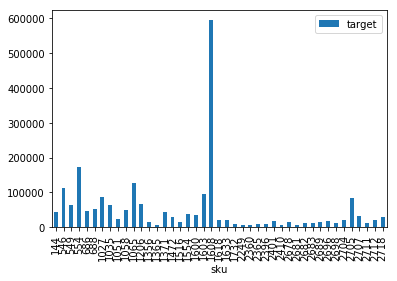

In [23]:
plt.figure(figsize=(12, 9));
avg = train[['sku', 'target']].groupby('sku').mean()
avg.plot(kind='bar');
#plt.grid(color='black', linestyle='--', linewidth=.5);
#plt.yticks(np.arange(0, 7, step=1.0));
#plt.xlabel("");
#plt.legend(loc='upper right',bbox_to_anchor=(1.7, 1.1));

# Peaks Analysis

## Extract peak indeces

In [24]:
def get_peaks(df, highest=True): 
    """
    La funzione get_min_significant_diff cerca di prendere quelle peak che sono realmente significative:
    guardo la differenza nel target tra monte e valle e si considerano tutti quei peaks che hanno una ampiezza maggiore
    di un certo delta, stabilito a seconda della time series
    
    return: (peak_value, peak_index, peak-valley)
    """
    peaks = []
    peak_idxs = []
    start_idx = df.index[0]
    end_idx = df.index[-1]
    i = start_idx 
    peak = df.loc[i, 'target']
    valley = df.loc[i, 'target']
    diff = []
    while(i < end_idx ):
        while(i < end_idx and df.loc[i, 'target'] >= df.loc[i+1, 'target']):
            i += 1
        valley = df.loc[i, 'target']
        while(i < end_idx and df.loc[i, 'target'] <= df.loc[i+1, 'target']):
            i += 1
        peak = df.loc[i, 'target']
        
        diff.append(peak-valley)
        peaks.append((peak, i, peak-valley))
    
    if highest==False:
        return [x[0] for x in peaks], [x[1] for x in peaks], [x[2] for x in peaks]
    
    
    diff = diff[:-1]    # alla fine peak - valley = 0, rimuoviamo l'ultimo valore
    def get_min_significant_diff(diff):
        diff = [(x, i) for i, x in enumerate(diff)]
        diff.sort(key=lambda x: x[0], reverse=True)
        residual = [diff[x][0] - diff[x+1][0] for x in range(len(diff)-1)]
        max_res_idx = np.argmax(residual)
        min_significant_diff = diff[max_res_idx][0]
        return min_significant_diff
    
    delta = get_min_significant_diff(diff)
    highest_peaks = [x for x in peaks if x[2] >= delta]
    
    # Create a list for each tuple element position
    pks = [x[0] for x in highest_peaks]
    idxs = [x[1] for x in highest_peaks]
    jumps = [x[2] for x in highest_peaks]

    return pks, idxs, jumps

## Check Frequencies of significant peaks

In [25]:
from collections import Counter

In [26]:
def get_common_peaks_day(highest=True):
    common_peak_days = []
    for s in tqdm(set(train.sku)):
        _, peak_idx, _ = get_peaks(train[train.sku==s], highest=highest)
        dt = list(train.loc[peak_idx].Date.values)
        common_peak_days.append(dt)
    common_peak_days = [x.astype(str).split('T')[0] for y in common_peak_days for x in y]
    return common_peak_days

In [27]:
common_peak_days = get_common_peaks_day()

<BarContainer object of 63 artists>

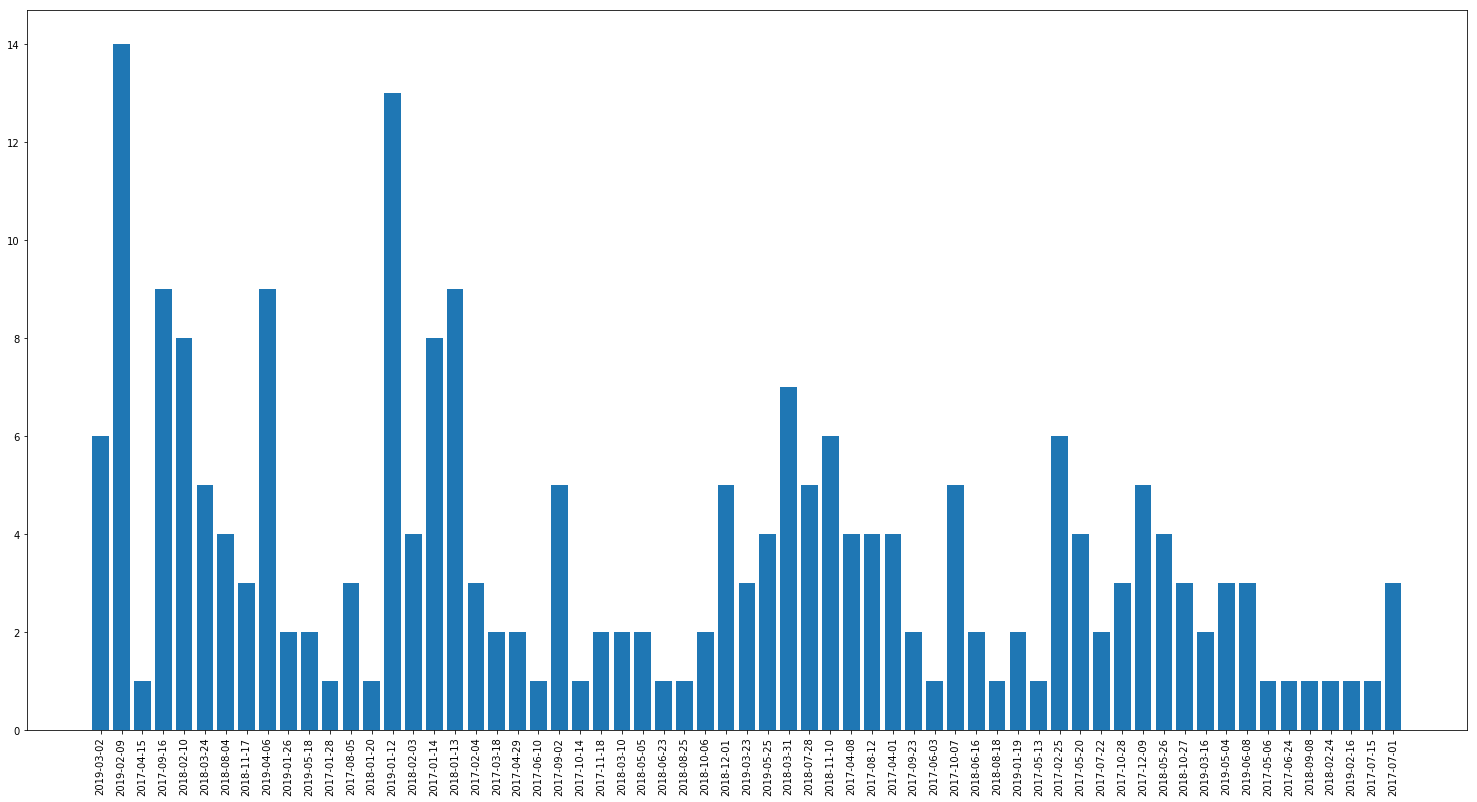

In [28]:
fig = plt.figure(figsize=(20,10))
ax = fig.add_axes([0,0,1,1])
plt.xticks(rotation=90)
ax.bar(list(Counter(common_peak_days).keys()), list(Counter(common_peak_days).values()))

## Check Frequencies of all peaks

In [29]:
common_peak_days = get_common_peaks_day(highest=False)

<BarContainer object of 115 artists>

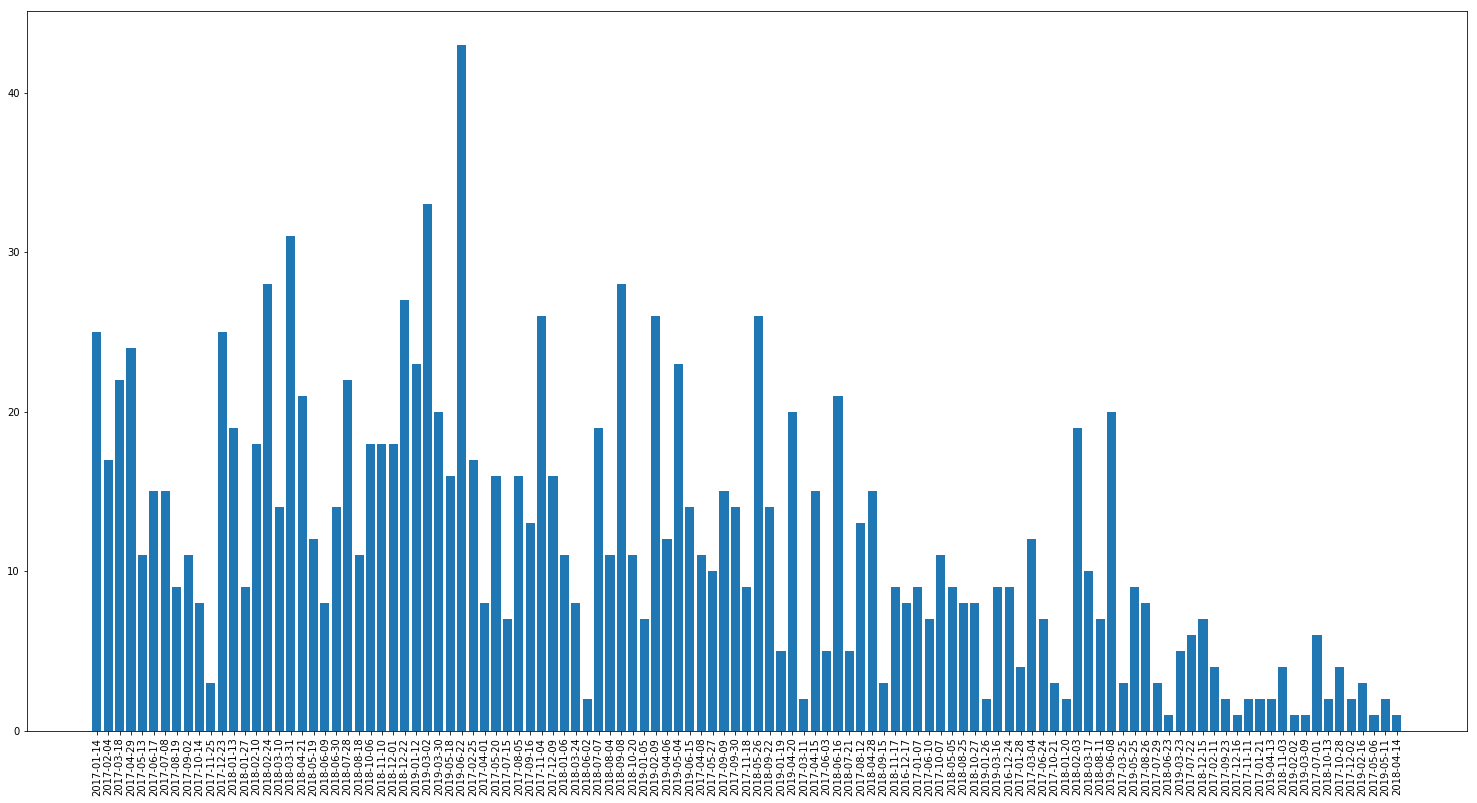

In [30]:
fig = plt.figure(figsize=(20,10))
ax = fig.add_axes([0,0,1,1])
plt.xticks(rotation=90)
ax.bar(list(Counter(common_peak_days).keys()), list(Counter(common_peak_days).values()))

In [31]:
Counter(common_peak_days).most_common()

[('2019-06-22', 43),
 ('2019-03-02', 33),
 ('2018-03-31', 31),
 ('2018-02-24', 28),
 ('2018-09-08', 28),
 ('2018-12-22', 27),
 ('2017-11-04', 26),
 ('2019-02-09', 26),
 ('2018-05-26', 26),
 ('2017-01-14', 25),
 ('2017-12-23', 25),
 ('2017-04-29', 24),
 ('2019-01-12', 23),
 ('2019-05-04', 23),
 ('2017-03-18', 22),
 ('2018-07-28', 22),
 ('2018-04-21', 21),
 ('2018-06-16', 21),
 ('2019-03-30', 20),
 ('2019-04-20', 20),
 ('2019-06-08', 20),
 ('2018-01-13', 19),
 ('2018-07-07', 19),
 ('2018-02-03', 19),
 ('2018-02-10', 18),
 ('2018-10-06', 18),
 ('2018-11-10', 18),
 ('2018-12-01', 18),
 ('2017-02-04', 17),
 ('2017-02-25', 17),
 ('2019-05-18', 16),
 ('2017-05-20', 16),
 ('2017-08-05', 16),
 ('2017-12-09', 16),
 ('2017-06-17', 15),
 ('2017-07-08', 15),
 ('2017-09-09', 15),
 ('2017-04-15', 15),
 ('2018-04-28', 15),
 ('2018-03-10', 14),
 ('2018-06-30', 14),
 ('2019-06-15', 14),
 ('2017-09-30', 14),
 ('2018-09-22', 14),
 ('2017-09-16', 13),
 ('2017-08-12', 13),
 ('2018-05-19', 12),
 ('2019-04-06

# Price variation

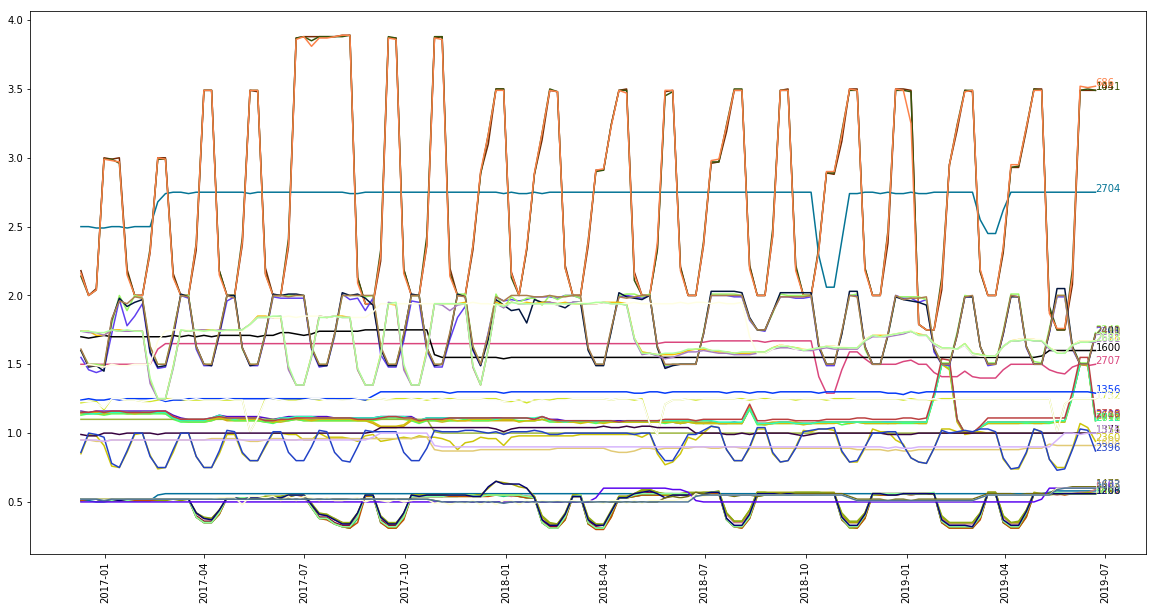

In [32]:
mycolors = np.random.choice(list(mpl.colors.XKCD_COLORS.keys()), len(set(train.sku)), replace=False)

plt.figure(figsize=(20,10))
plt.xticks(rotation=90)
for i, s in enumerate(set(train.sku)):
    plt.plot(train[train.sku==s].Date, train[train.sku==s].price,  color=mycolors[i])
    last_x, last_y = train[train.sku==s].Date.values[-1], train[train.sku==s].price.values[-1]
    plt.text(last_x, last_y, str(s), color=mycolors[i])

# Correlations

/usr/local/lib/python3.7/site-packages/seaborn/axisgrid.py:2065: UserWarning: The `size` parameter has been renamed to `height`; pleaes update your code.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.7/site-packages/numpy/lib/histograms.py:824: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/usr/local/lib/python3.7/site-packages/numpy/lib/histograms.py:825: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


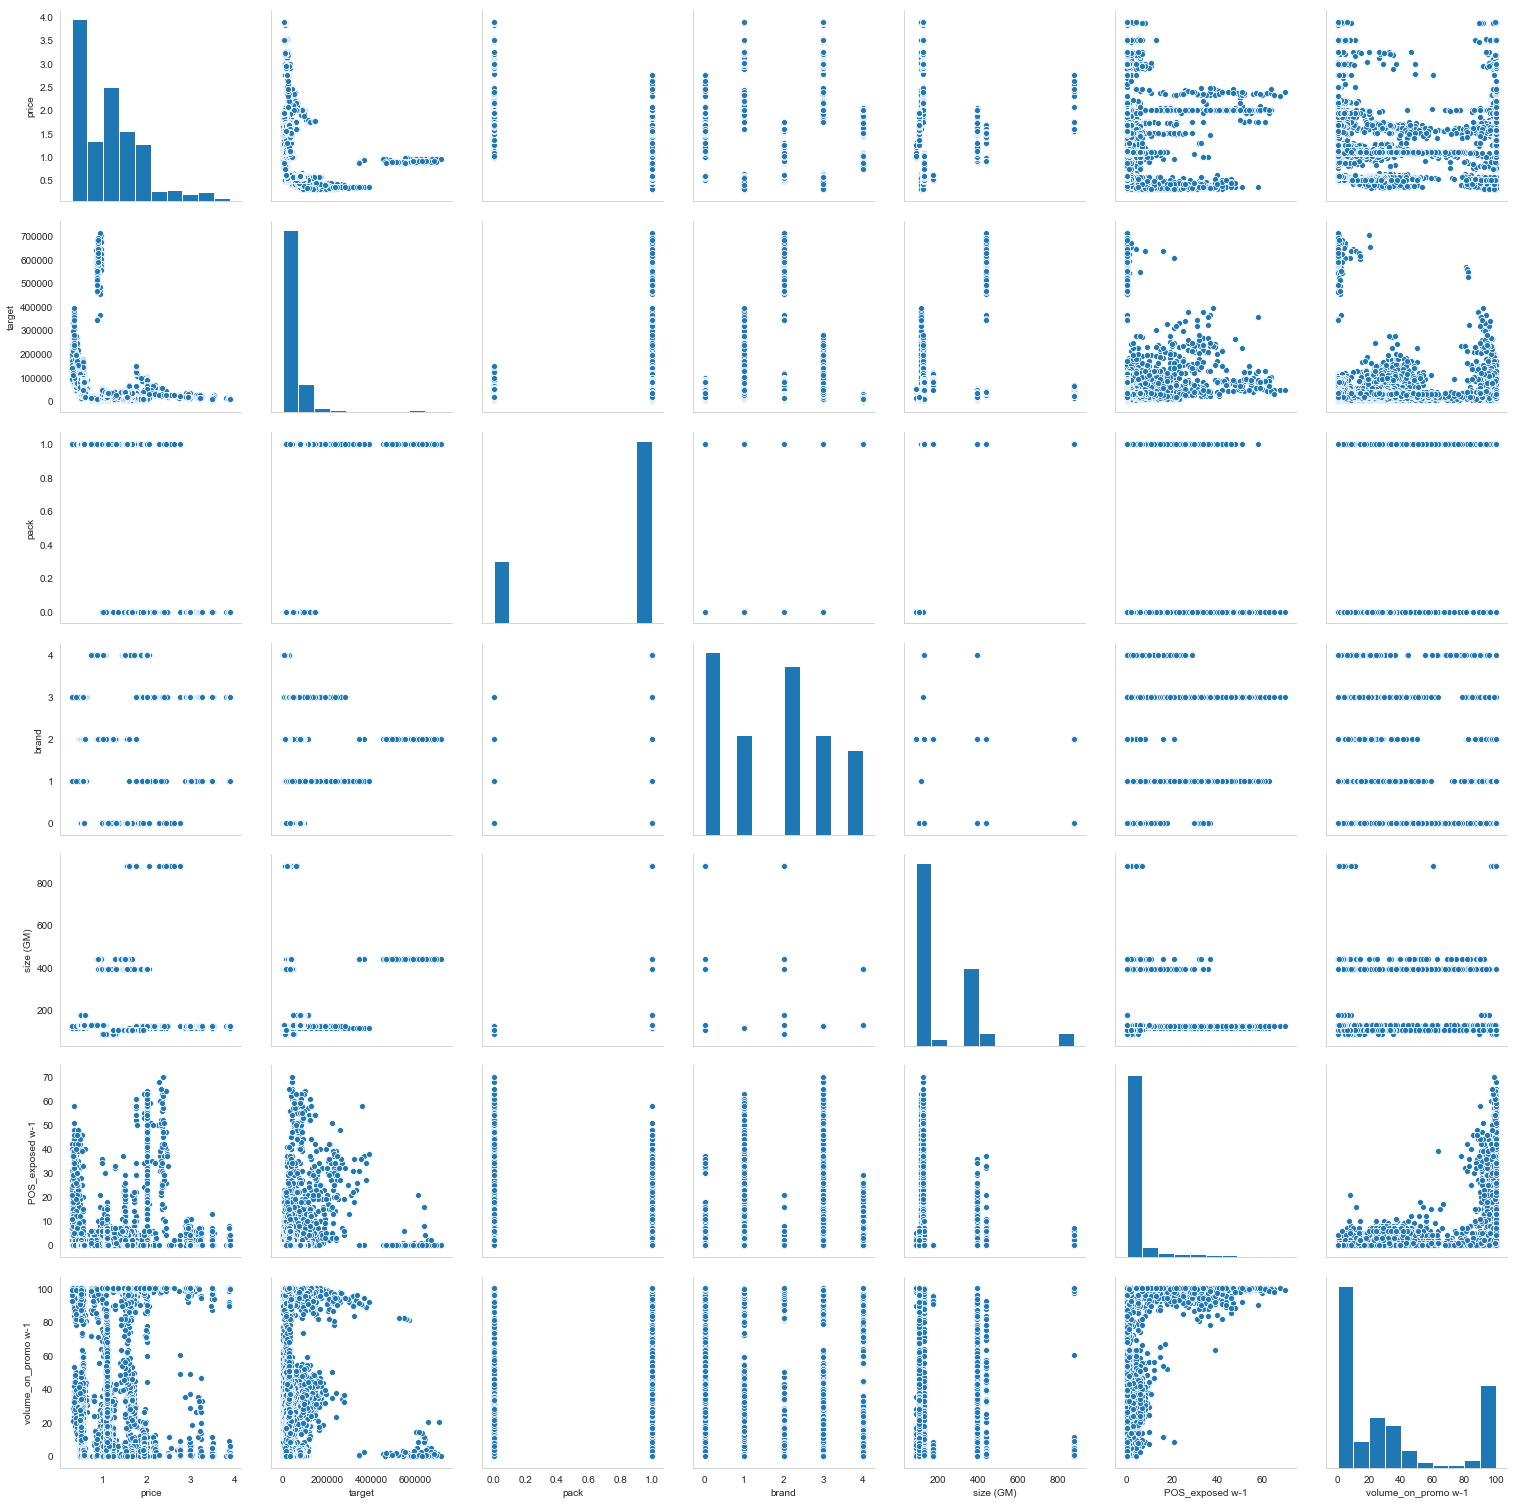

In [60]:
sns.set_style("whitegrid", {'axes.grid' : False})
sns.pairplot(df[['price', 'target', 'pack', 'brand', 'size (GM)', 'POS_exposed w-1', 'volume_on_promo w-1']], size=3)

price-target --> Le vendite si alzano più i prezzi sono bassi, con qualche variazione intorno a 2

pack-target --> Ci sono più vendite quando pack=1

size-target --> Più vendite quando la size è piccola

In [34]:
res = []
for s, p in zip(train.sku, train.pack):
    res.append(str(s) + '_' + str(p))
    
len(set(res)) # = 43 -> uno sku ha sempre il solito pack: probabilmente è per questo che nelle feature importance
              # pack è praticamente inutile

43

In [35]:
res = []
for s, b in zip(train.sku, train.brand):
    res.append(str(s) + '_' + str(p))
    
len(set(res)) # = 43 --> Stessa cosa di prima

43

In [58]:
res = []
for p, b in zip(train.pack, train.brand):
    res.append(str(p) + '_' + str(p))
    
train['pack_brand'] = res
train[['sku','pack_brand']].drop_duplicates(['sku','pack_brand']).groupby('sku').count()

# Ogni sku ha sempre lo stesso pack_brand

,pack_brand
sku,
144,1
546,1
549,1
554,1
686,1
688,1
1027,1
1035,1
1051,1


In [59]:
train = train.drop('pack_brand', axis=1)

# Feature Engineering

In [36]:
# Forse dopo aver fatto le features ci merita togliere le righe del primo giorno in assoluto [che hanno svariati campi = Nan]

Queste features sono da eseguire sul df = pd.concat([train, test]), non in parti spezzettate

In [197]:
train = df[~df.target.isna()]

In [89]:
# Moving Average
def moving_average(df, k, inverse_interpolation=True):
    # RETURN DF
    df = df.sort_values(['sku','Date']).reset_index(drop=True)
    curr_idx = 0
    previous_k_idx = curr_idx
    current_sku = None
    """
    k: indicates how much of the past consider [at most]
    """
    res = []
    for i, s, sal in tqdm(zip(df.index, df.sku, df['sales w-1'])):
        if not s == current_sku or current_sku is None:
            if inverse_interpolation: 
                res.append(sal)
            else:
                res.append(np.nan)
            current_sku = s
            curr_idx += 1
            previous_k_idx = i
        else:
            avg = np.mean(df.loc[previous_k_idx:curr_idx, 'sales w-1'].values)
            
            res.append(avg)
            
            if curr_idx - previous_k_idx == k:
                previous_k_idx += 1
            curr_idx += 1
            
            if curr_idx - previous_k_idx == k+1:
                print(f"Exceeded: {curr_idx - previous_k_idx}")
    
    df['moving_average'] = res
    return df

In [213]:
def exponential_weighted_moving_average(df, com=0.5):
    df = df.sort_values(['sku','Date'])
    sku_values = list(set(df.sku.values))
    sku_values = sorted(sku_values)
    res = []
    for s in tqdm(sku_values):
        ewma = df[df.sku==s]['sales w-1'].ewm(com=com).mean().values
        res.append(ewma)
    res = [item for x in res for item in x]    
    return res

In [84]:
# Pendenza
def slope(df):
    """
    slope values = [0,+1, -1]
    """
    df = df.sort_values(['sku','Date']).reset_index(drop=True)
    curr_idx = 0
    current_sku = None
    res_slope = []
    res_changes = []
    for i, s, s_1 in tqdm(zip(df.index, df.sku, df['sales w-1'])):
        if not current_sku == s or current_sku is None:
            current_sku = s
            curr_idx += 1
            res_slope.append(0)
            res_changes.append(0)
            
        else:
            res_slope.append(np.sign(s_1 - df.loc[curr_idx-1, 'sales w-1']))
            res_changes.append(s_1 - df.loc[curr_idx-1, 'sales w-1'])
            curr_idx += 1
    return res_slope, res_changes

In [198]:
train = moving_average(train, 20)

In [199]:
_ , train['increment'] = slope(train)

In [219]:
train['exp_ma'] = exponential_weighted_moving_average(train, com=0.3)

In [273]:
#train['year'] = train.Date.dt.strftime('%Y %m %d').str.split(" ").apply(lambda x:x[0]).astype(int)
train['month'] = train.Date.dt.strftime('%Y %m %d').str.split(" ").apply(lambda x:x[1]).astype(int)
train['day'] = train.Date.dt.strftime('%Y %m %d').str.split(" ").apply(lambda x:x[2]).astype(int)

In [286]:
train = train.drop('year', axis=1)

# Train-Validation split

In [287]:
val_sku = list(set(train[train.scope==1].sku))

In [288]:
#train.Date = le.fit_transform(train.Date)

In [289]:
train = train.fillna(0)

In [290]:
train_dates = train.sort_values('Date').drop_duplicates('Date', keep='first').Date.values
k = int(np.floor(len(train_dates) * 0.20))
val_dates = train_dates[-k:]
mask = train.Date.isin(val_dates)

In [291]:
val = train[mask]
train_ = train[~mask]

In [292]:
val_date = val['Date'].drop_duplicates().values

In [293]:
from lightgbm import LGBMRegressor

In [294]:
lgb = LGBMRegressor(metric='mape')

In [295]:
def MAPE(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [296]:
MAPEs = []
preds = []
for i in range(len(val_date)):
    lgb.fit(train_.drop(['Date','scope', 'target'], axis=1), train_['target'], categorical_feature=['sku', 'pack', 'brand'])
    mask_prediction = (val.Date==val_date[i]) & (val.sku.isin(val_sku))
    predictions = lgb.predict(val[mask_prediction].drop(['Date','scope', 'target'], axis=1))
    preds.append(predictions)
    #MAPEs.append(MAPE(val[mask_prediction].target, predictions))
    train_ = pd.concat([train_, val[val.Date==val_date[i]]])

#MAPE(val.target, preds)
#print(MAPEs)
preds = [x for p in preds for x in p]

/usr/local/lib/python3.7/site-packages/lightgbm/basic.py:1295: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['brand', 'pack', 'sku']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
/usr/local/lib/python3.7/site-packages/lightgbm/basic.py:1295: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['brand', 'pack', 'sku']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
/usr/local/lib/python3.7/site-packages/lightgbm/basic.py:1295: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['brand', 'pack', 'sku']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
/usr/local/lib/python3.7/site-packages/lightgbm/basic.py:1295: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['brand', 'pack', 'sku']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature)

In [297]:
MAPE(val[val.sku.isin(val_sku)].target, preds)

127.49598850515957

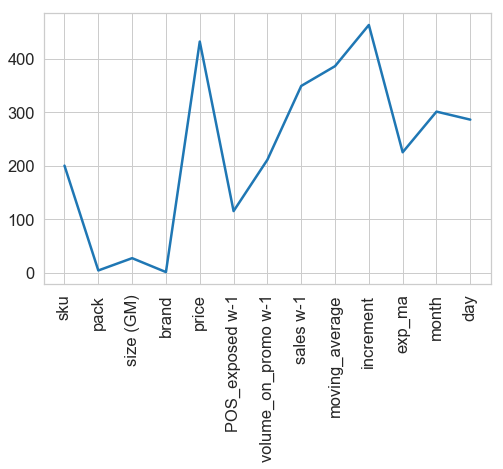

In [298]:
plt.figure(figsize=(8,5))
plt.xticks(rotation=90)
plt.plot(train_.drop(['Date','scope', 'target'], axis=1).columns, lgb.feature_importances_)